# Minimum variance portfolio with risk parity

In [1]:
%matplotlib inline

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 12

In [3]:
import requests
import bs4 as bs
import pandas_datareader as pdr

/Users/mirca/opt/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
import riskparityportfolio as rp
import numpy as np

In this notebook, we will check out the necessary interface to take into account the mean return and the variance while optimizing risk parity portfolios.

## Accessing financial data from Yahoo! finance
In this step we are going to download stocks prices data from Yahoo! finance. For that, I chose to pick the 50 most representative stocks of the S&P 500 index.

The following lines of code web scrapes the website https://www.slickcharts.com/sp500 and gets the 50 most representative stocks of the S&P 500 index:

In [5]:
resp = requests.get('https://www.slickcharts.com/sp500')
soup = bs.BeautifulSoup(resp.text, 'html.parser')
table = soup.find('table', {'class': 'table table-hover table-borderless table-sm'})
stocks = [fn['href'][len("/symbol/"):] for fn in table.find_all('a') if fn['href'].startswith('/symbol')]
stocks_ = [stocks[i] for i in range(len(stocks)) if i % 2 == 0][:10]

In [6]:
print(stocks_)

['MSFT', 'AAPL', 'AMZN', 'FB', 'BRK.B', 'JNJ', 'GOOG', 'GOOGL', 'V', 'JPM']


In [7]:
prices = pdr.get_data_yahoo(stocks_, start = "2018-12-31", end = "2019-12-31")[['Adj Close']]

/Users/mirca/opt/miniconda3/lib/python3.7/site-packages/pandas_datareader/base.py:270: SymbolWarning: Failed to read symbol: 'BRK.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


In [8]:
prices.dropna(axis='columns', inplace=True)
prices.columns = prices.columns.droplevel(0)

In [9]:
log_returns = prices.apply(np.log).apply(np.diff)

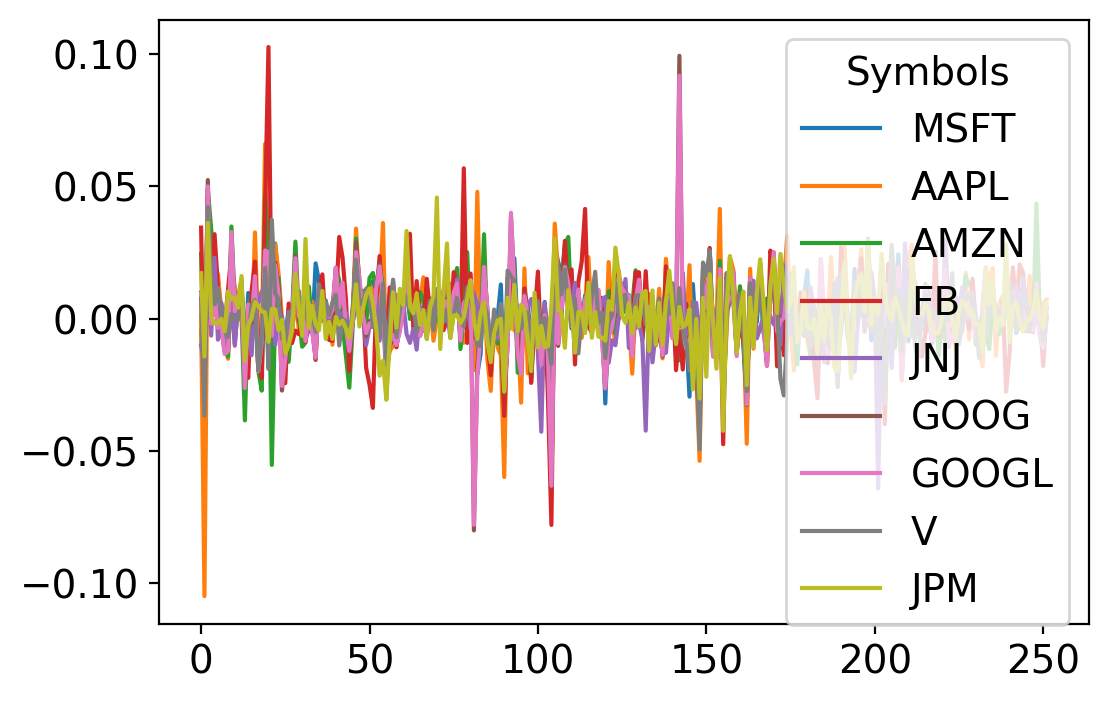

In [10]:
log_returns.plot()

## Optimization problem

**riskparity.py** allows users to account for the variance of the designed portfolio, i.e., we solve the following optimization problem:

\begin{array}{ll}
 \underset{\mathbf{w}}{\textsf{minimize}} &
 R(\mathbf{w}) + \lambda \mathbf{w}^{\top}\boldsymbol{\Sigma}\mathbf{w}\\
 \textsf{subject to} & \mathbf{0} \leq \mathbf{w}, \texttt{sum}(\mathbf{w}) = 1, 
\end{array}

In [63]:
Sigma = np.cov(log_returns.T)

In [64]:
risk_budget = np.ones(len(Sigma)) / len(Sigma) 

In [65]:
my_portfolio = rp.RiskParityPortfolio(covariance=Sigma, budget=risk_budget)

In [71]:
risk_parity = []
volatility = []
for lmd in 10 ** np.arange(-5, 10, .25):
    my_portfolio.add_variance(lmd=lmd)
    my_portfolio.design()
    risk_parity.append(my_portfolio.risk_concentration.evaluate())
    volatility.append(my_portfolio.volatility)

  0%|          | 0/500 [00:00<?, ?it/s]


Text(0.5, 0, 'risk parity')

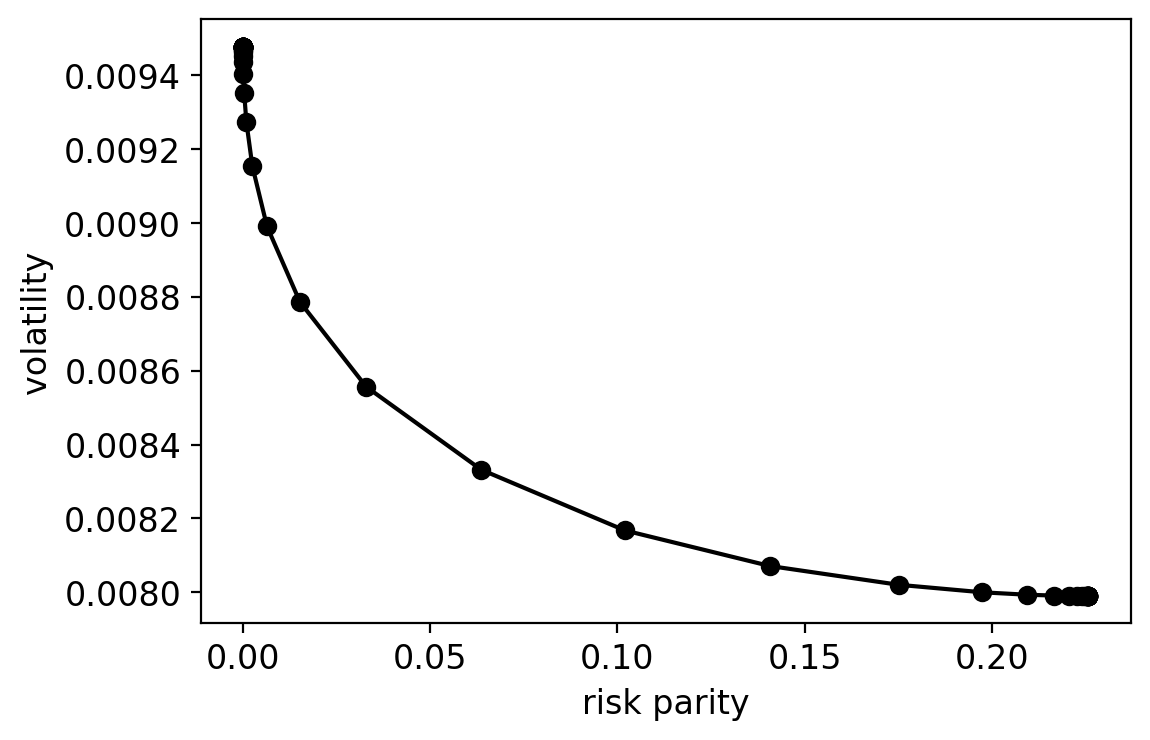

In [72]:
plt.plot(risk_parity, volatility, 'ko')
plt.plot(risk_parity, volatility, 'k-')
plt.ylabel("volatility")
plt.xlabel("risk parity")

Text(0.5, 1.0, 'Risk Contributions $\\lambda = 5623413252.0$')

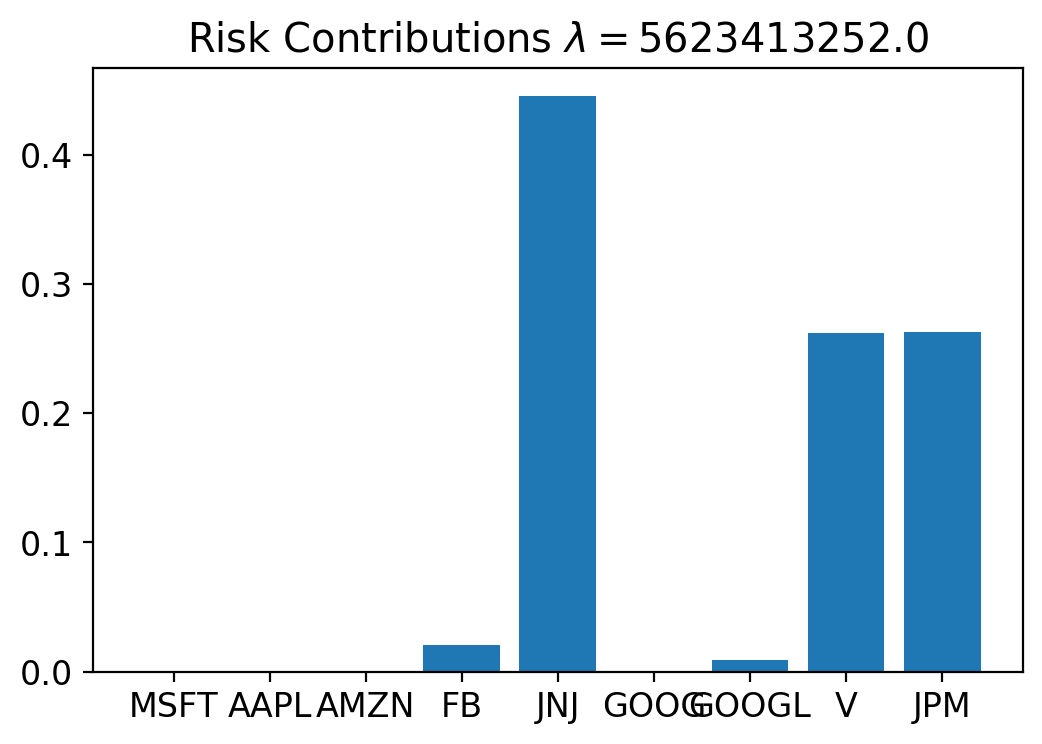

In [73]:
plt.bar(log_returns.columns, height=my_portfolio.risk_contributions)
plt.title(r"Risk Contributions $\lambda = {}$".format(np.round(lmd)))

<BarContainer object of 9 artists>

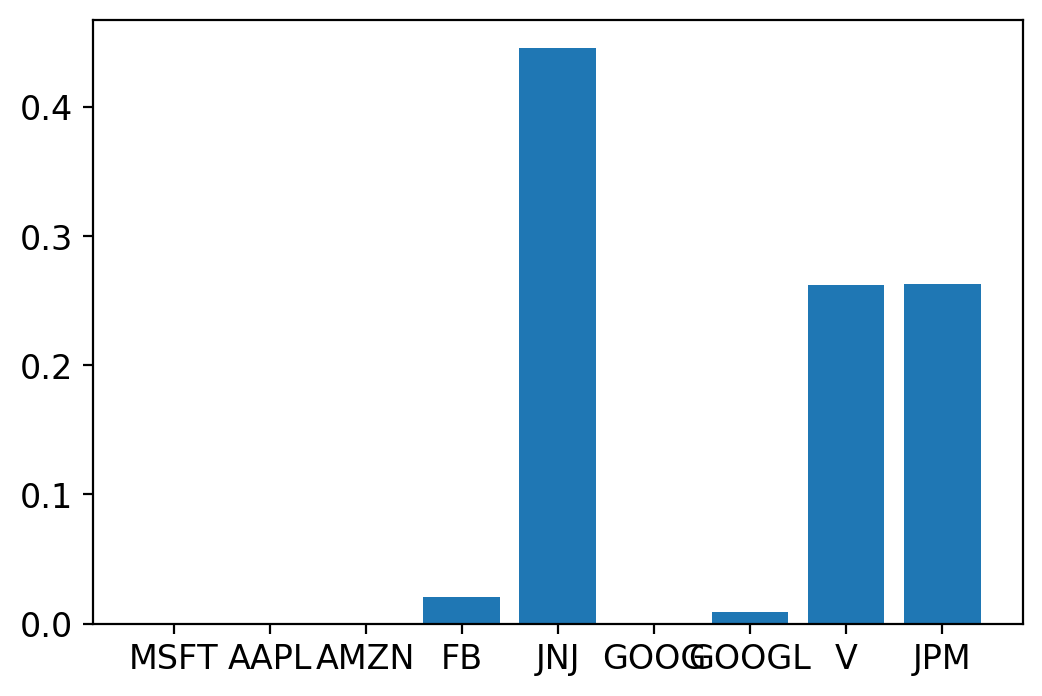

In [74]:
plt.bar(log_returns.columns, height=my_portfolio.weights)

## Adding the variance

Likewise, **riskparity.py** allows users to include the variance of the portfolio into the objective function:

\begin{array}{ll}
 \underset{\mathbf{w}}{\textsf{minimize}} &
 R(\mathbf{w}) + \lambda \mathbf{w}^{\top}\boldsymbol{\Sigma}\mathbf{w}\\
 \textsf{subject to} & \mathbf{w} \geq \mathbf{0}, \texttt{sum}(\mathbf{w}) = 1
\end{array}

Let's also investigate the Volatility x Risk Concentration profile using the same parameters as in the previous example.

In [13]:
my_portfolio = rp.RiskParityPortfolio(covariance=Sigma, budget=b)

In [14]:
risk_parity = []
volatility = []
for lmd in 10 ** np.arange(-5, 0, .25):
    my_portfolio.add_variance(lmd=lmd)
    my_portfolio.design()
    risk_parity.append(my_portfolio.risk_concentration.evaluate())
    volatility.append(np.sqrt(my_portfolio.variance))

  3%|▎         | 14/500 [00:00<00:03, 129.05it/s]


Text(0.5,0,'risk parity')

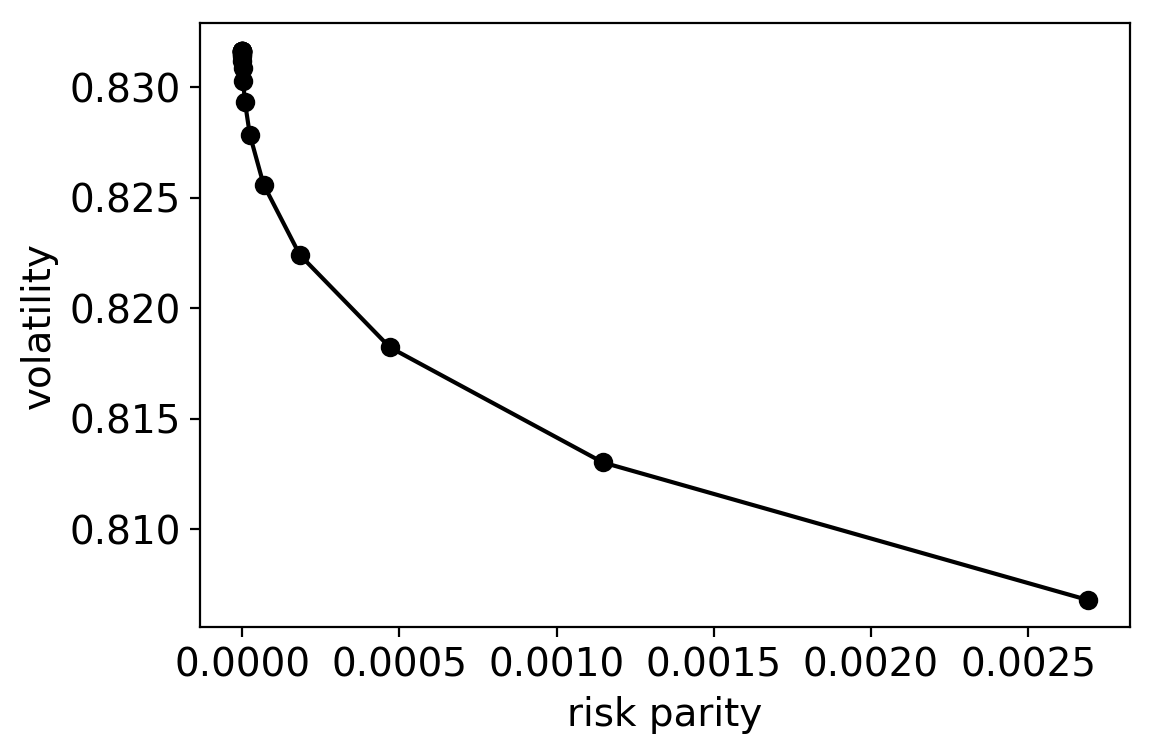

In [15]:
plt.plot(risk_parity, volatility, 'ko')
plt.plot(risk_parity, volatility, 'k-')
plt.ylabel("volatility")
plt.xlabel("risk parity")